In [173]:
#libraries
import numpy as np
import argparse
import imutils
import time
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
import matplotlib.pyplot as plt

import os
print(os.listdir("../NN"))
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice

['.ipynb_checkpoints', 'Untitled.ipynb']


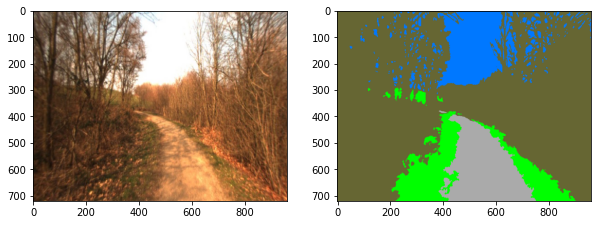

In [40]:
#create image datastores from https://www.kaggle.com/mukulkr/camvid-segmentation-using-unet

dataset_path = Path("../freiburg_forest_annotated/train")
label_path = Path("../freiburg_forest_annotated/train/GT_color")
list(dataset_path.iterdir())

def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')
        
train_imgs = list((dataset_path / "rgb").glob("*.png"))
train_labels = list((dataset_path / "GT_color").glob("*.png"))
#val_imgs = list((dataset_path / "val").glob("*.png"))
#val_labels = list((dataset_path / "val_labels").glob("*.png"))
#test_imgs = list((dataset_path / "test").glob("*.png"))
#test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels))

def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem[:-8] +"_mask.png")))
    return pairs


train_pair = make_pair(train_imgs, "GT_color", dataset_path)

temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(720,960)))
mask = img_to_array(load_img(temp[1], target_size = (720,960)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [112]:
labelIDs = [[170,170,170],[0,255,0],[102,102,51],[0,60,0],[0,120,255],[0,0,0]]


class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
       # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            X[i,] = img

            # Store class
            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            print(label)
            #y[i] = label[ID]

        return X, keras.utils.to_categorical(y, num_classes=6)


In [114]:
train_generator = DataGenerator(train_pair,labelIDs,batch_size=4, dim=(32,32,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

X,y = train_generator.__getitem__(1)
#y.shape

[[[102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]
  ...
  [102. 102.  51.]
  [  0. 120. 255.]
  [102. 102.  51.]]

 [[102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]
  ...
  [  0. 120. 255.]
  [102. 102.  51.]
  [102. 102.  51.]]

 [[102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]
  ...
  [102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]]

 ...

 [[102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]
  ...
  [102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]]

 [[102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]
  ...
  [102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]]

 [[102. 102.  51.]
  [102. 102.  51.]
  [102. 102.  51.]
  ...
  [  0. 255.   0.]
  [102. 102.  51.]
  [102. 102.  51.]]]
[[[  0. 120. 255.]
  [  0. 120. 255.]
  [  0. 120. 255.]
  ...
  [  0. 120. 255.]
  [  0. 120. 255.]
  [  0. 120. 255.]]

 [[  0. 120. 255.]
  [  0. 120. 255.]
  [  0. 120. 255.]
  ...
  [  0. 120. 255.]
  [  0. 120. 255.]
  [  0. 120. 255.]]

 [[102. 102.  51.]

IndexError: index 23391882669552 is out of bounds for axis 1 with size 6

In [174]:
## NEW START ##


import cv2
import random 

def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    random.shuffle(n)

    while (True):
        img = np.zeros((batch_size, 512, 512, 3)).astype('float')
        mask = np.zeros((batch_size, 512, 512, 3)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to 16, c = 0. 

            train_img = cv2.imread(img_folder+'/'+n[i])/255.
            train_img =  cv2.resize(train_img, (512, 512))# Read an image from folder and resize

            img[i-c] = train_img #add to array - img[0], img[1], and so on.

            temp = n[i]
            file_stem = temp[:-12]
            print(file_stem)
            train_mask = cv2.imread(mask_folder+'/'+file_stem+'_mask.png')/255.
            train_mask = cv2.resize(train_mask, (512, 512))
            #train_mask = train_mask.reshape(512, 512, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]

            mask[i-c] = train_mask

        c+=batch_size
        if(c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
                      # print "randomizing again"
        yield img, mask




train_frame_path = '../freiburg_forest_annotated/train/rgb'
train_mask_path = '../freiburg_forest_annotated/train/GT_color'

#val_frame_path = '/path/to/validation_frames'
#val_mask_path = '/path/to/validation_frames'

# Train the model
train_gen = data_gen(train_frame_path,train_mask_path, batch_size = 16)
#val_gen = data_gen(val_frame_path,val_mask_path, batch_size = 4)

In [176]:
# create a basic convolutional neural network
cnn = keras.models.Sequential() 
cnn.add(keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(512,512,3)))
cnn.add(keras.layers.MaxPooling2D(2, 2))
cnn.add(keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(keras.layers.MaxPooling2D(2, 2))
cnn.add(keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(32, activation="relu"))
cnn.add(keras.layers.Dense(6, activation="softmax"))
cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
flatten_23 (Flatten)         (None, 1048576)           0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)              

In [177]:
# compile the model
cnn.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# train the model
history = cnn.fit_generator(train_gen, steps_per_epoch=train_steps ,epochs=30)

b336-894
b347-196
b196-39
b175-943
b77-9598
b170-601
b88-8491
b360-407
b94-9007
b165-558
b97-1436
b165-789
b371-451
b40-945
b50-2417
b206-696
Epoch 1/30


ValueError: in user code:

    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:532 train_step  **
        loss = self.compiled_loss(
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1527 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4561 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/mikailg/.conda/envs/vipr/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1117 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None, None, None) and (None, 6) are incompatible


In [ ]:
# evaluate the model
score = cnn.evaluate(x=X_norm_test, y=y_cate_test)

print("test loss:     %g" % score[0])
print("test accuracy: %g" % score[1])